# Black Scholes by Monte Carlo Simulations

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

The Black Scholes model states that the asset price at time $t$ follows a geometric brownian motion with constant volatility $\sigma$ and constant drift $\mu$:

$ dS_t = S_t\mu dt + S_t \sigma dW_t$ 

Since we are in risk free world, $\mu = r$

Recall ito's lemma for a function $G(S)$ if $S$ is an Itô Process.

\begin{align*}dG = ( \frac{\partial G}{\partial S}Sr + \frac{\partial G}{\partial t} + \frac{1}{2}\frac{\partial^2 G}{\partial S^2}S^2\sigma^2 )dt + \frac{\partial G}{\partial S}S\sigma dW(t) \end{align*}

If we apply Ito's lemma to $f = ln(S_t)$, we have:

$\frac{\partial f}{\partial S} = \frac{1}{S}$ , $\frac{\partial f}{\partial t} = 0$ , $\frac{\partial^2 f}{\partial S^2} = - \frac{1}{S^2}$

Hence,

\begin{align*}df & =( \frac{1}{S}Sr + 0 - \frac{1}{2}\frac{1}{S^2}S^2\sigma^2 )dt + \frac{1}{ S}S\sigma dW(t) \\ & = (r - \frac{\sigma^2}{2})dt\ + \sigma dW\end{align*}

This yields,

\begin{align*} S_t = S_0e^{(r - \frac{\sigma^2}{2})t\ + \sigma W_t} \end{align*}


In [2]:
class BsMonteCarlo:
    def __init__(self, S0, r, sigma, T, num_simulations, num_steps, antithetic = False, importance = False):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.num_simulations = num_simulations
        self.num_steps = num_steps
        self.antithetic = antithetic
        self.importance = importance
    
    def gbmPaths(self):
        """ 
        Generate asset trajectories under the Black Scholes model.
        :param: antithetic: generate antithetic paths. We can divide by 2 the number of paths. It can then reduce variance.
        :return: A (num_simulations, num_steps + 1) array containing simulated price paths
        """

        # Initialize the time interval per steps
        dt = self.T / self.num_steps
        # Initialize the array containing the simulated prices
        paths = np.zeros((self.num_simulations, self.num_steps + 1))
        paths[:,0] = self.S0
        # Simulate paths
        for t in range(1, self.num_steps + 1):
            Z = np.random.standard_normal(self.num_simulations // (2 if self.antithetic else 1))
            if self.antithetic:
                Z = np.concatenate([Z, -Z])
            paths[:,t] = paths[:,t - 1] * np.exp((self.r - self.sigma**2 / 2) * dt +self.sigma * Z * np.sqrt(dt))
        return paths
    

    
    def callPrice(self, K):
        """
        Calculates the price of a European Call option using Monte Carlo

        :param K: Strike price
        :return: Estimated price oif the European Call Option
        """
        # Simulate the paths
        paths = self.gbmPaths()
        # Calculate the call payoff for each path
        payoff = np.maximum(paths[:-1] - K, 0)
        # Calculate the call price which is the discounted average payoff 
        call_price = np.exp(-self.r * self.T) * np.mean(payoff)
        return call_price
    

    
    def putPrice(self, K):
        """
        Calculates the price of a European put option using Monte Carlo.
        
        :param K: Strike price
        :return: Estimated price of the European put option
        """
        # Simulate the paths
        paths = self.gbmPaths()
        # Calculate the put payoff for each path
        payoff = np.maximum(K - paths[:, -1], 0)
        # Calculate the put price which is the discounted average payoff 
        put_price = np.exp(-self.r * self.T) * np.mean(payoff)
        return put_price



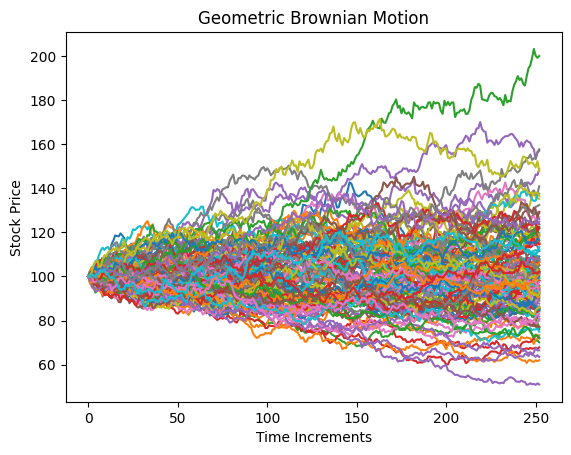

In [3]:
S0 = 100
r = 0.05
sigma = 0.2
T = 1
K = 100
num_simulations = 120
num_steps = 252
bs_mc = BsMonteCarlo(S0, r, sigma, T, num_simulations, num_steps)
paths = pd.DataFrame(bs_mc.gbmPaths()).T
plt.plot(paths)
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion");

## Call Price

In [6]:
np.random.seed(123)
S0 = 95
r = 0.05
sigma = 0.2
T = 1
K = 100
num_simulations = 100000
num_steps = 252
bs_mc = BsMonteCarlo(S0, r, sigma, T, num_simulations, num_steps)
call_price = bs_mc.callPrice(K)
print(f"Estimated European call option price: {call_price:.2f}")

Estimated European call option price: 4.01


In [ ]:
np.random.seed(123)
S0 = 95
r = 0.05
sigma = 0.2
T = 1
K = 100
num_simulations = 50000
num_steps = 252
bs_mc = BsMonteCarlo(S0, r, sigma, T, num_simulations, num_steps, antithetic = True)
call_price = bs_mc.callPrice(K)
print(f"Estimated European call option price: {call_price:.2f}")

Estimated European call option price: 4.00
